In [1]:
import pandas as pd
from pathlib import Path
from plotnine import *
from scipy.stats import ttest_ind

In [2]:
def do_t_test(
        x: pd.Series, flare_flags: pd.Series, *, equal_var: bool = True
    ) -> float:
    result = ttest_ind(x[flare_flags], x[~flare_flags], equal_var=equal_var)
    return result.statistic**2

def calc_all_fisher_scores(partition: int) -> pd.DataFrame:
    partition_dir = Path("..") / ".." / "data" / "processed" / f"partition{partition}"
    summary_df = pd.read_parquet(partition_dir / "summary_df.parquet")
    corrected_summary_df = pd.read_parquet(
        partition_dir / "corrected_summary_df.parquet"
    )

    fisher_scores = (
        summary_df
        .drop(columns=["partition", "type", "flare_class", "ar_num", "file"])
        .apply(lambda x: do_t_test(x, summary_df["type"] == "FL"))
        .reset_index(name="Score")
        .rename(columns={"index": "Specs"})
    )
    corrected_fisher_scores = (
        corrected_summary_df
        .drop(columns=["partition", "type", "flare_class", "ar_num", "file"])
        .apply(lambda x: do_t_test(x, corrected_summary_df["type"] == "FL"))
        .reset_index(name="CORR_Score")
        .rename(columns={"index": "CORR_Specs"})
        .assign(
            CORR_Specs=lambda df: (
                df["CORR_Specs"]
                .str.replace(
                    "^(R_VALUE|[A-Z0-9]+)_", r"\1_CORRECTED_", regex=True
                )
            )
        )
    )
    all_fisher_scores = (
        pd.concat([fisher_scores, corrected_fisher_scores], axis=1)
        .assign(
            IMP=lambda x: x["CORR_Score"] - x["Score"],
            Best_Score=lambda x: x["Score"].combine(x["CORR_Score"], max)
        )
        .sort_values("Best_Score", ascending=False, ignore_index=True)
    )

    return all_fisher_scores

In [3]:
all_fisher_scores = []
improvements = []
for partition in range(1, 6):
    out_dir = Path("..") / ".."
    all_fisher_scores.append(calc_all_fisher_scores(partition))
    improvements.append(
        pd.read_csv(out_dir / f"Partition{partition}Improvements.csv")
    )
    print(all_fisher_scores[partition - 1].equals(improvements[partition - 1]))

False
False
False
False
False


In [4]:
def make_comparison(
        all_fisher_scores: pd.DataFrame, improvements: pd.DataFrame
    ) -> pd.DataFrame:
    comparison = (
        all_fisher_scores[["Specs", "Score"]]
        .sort_values("Specs", ignore_index=True)
        .merge(
            improvements[["Specs", "Score"]],
            on="Specs", suffixes=["", "_orig"]
        )
        .assign(
            suffix=lambda df: (
                df["Specs"].str.replace("^(R_VALUE|[A-Z0-9]+)_", "", regex=True)
            ),
            diff=lambda df: df["Score"] - df["Score_orig"],
            abs_diff=lambda df: df["diff"].abs(),
            rel_diff=lambda df: df["diff"] / df["Score_orig"],
            abs_rel_diff=lambda df: df["rel_diff"].abs()
        )
    )
    return comparison

def make_comparison_plot(comparison: pd.DataFrame, partition: int) -> ggplot:
    comparison_plot_data = (
        comparison[["suffix", "diff", "abs_diff", "rel_diff", "abs_rel_diff"]]
        .melt(id_vars="suffix", var_name="metric", value_name="val")
        .assign(
            metric=lambda df: (
                pd.Categorical(
                    df["metric"],
                    ["diff", "abs_diff", "rel_diff", "abs_rel_diff"]
                )
            )
        )
    )
    plot = (
        ggplot(comparison_plot_data, aes(x="suffix", y="val")) +
        facet_wrap("metric", scales="free_x") +
        geom_boxplot() +
        coord_flip() +
        ggtitle(f"Partition {partition}") +
        theme_bw()
    )
    return plot

In [5]:
comparisons = []
for partition in range(1, 6):
    comparisons.append(
        make_comparison(
            all_fisher_scores[partition - 1], improvements[partition - 1]
        )
    )

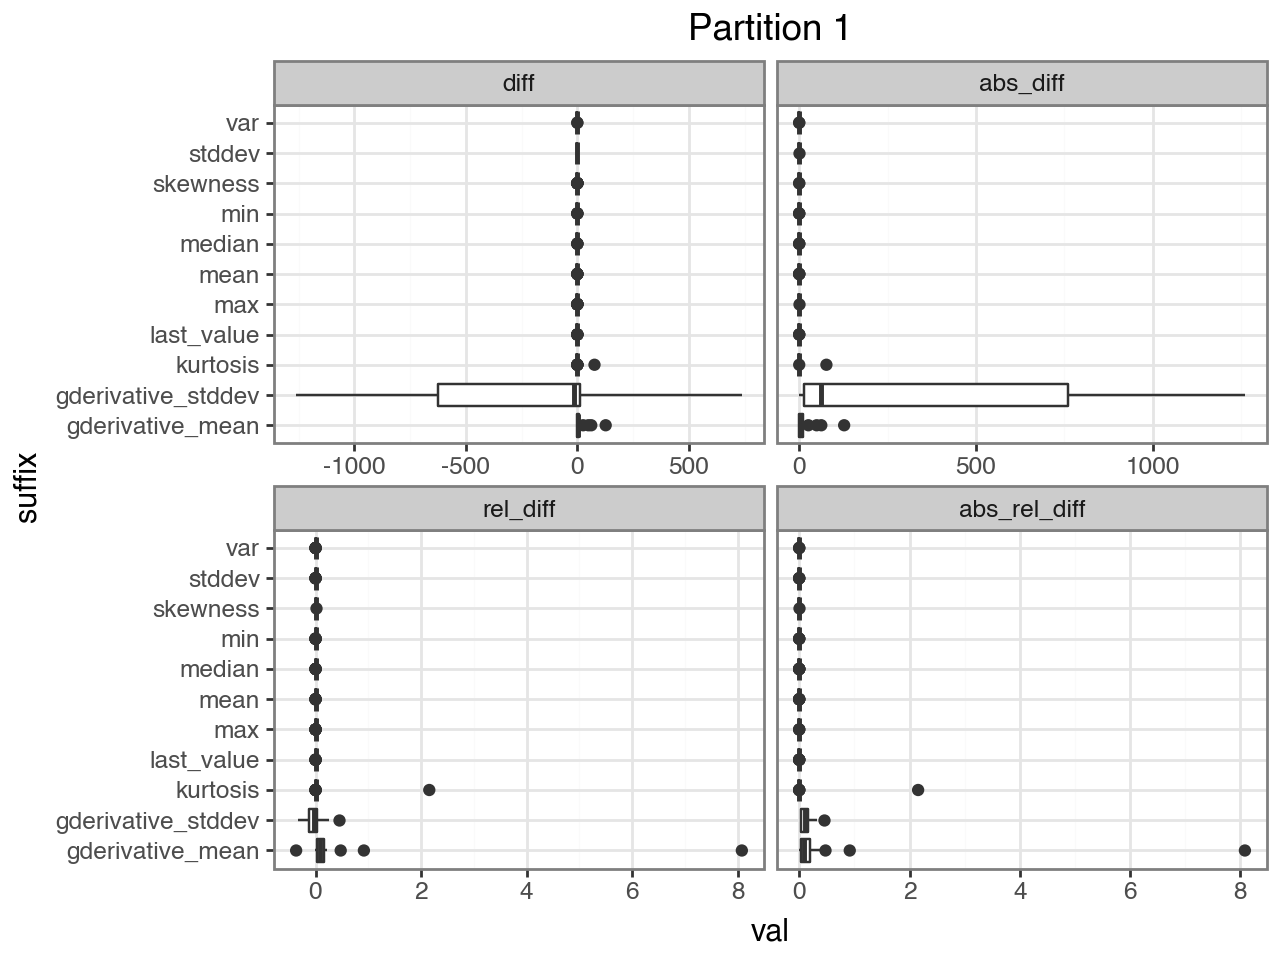

/Users/vkverma/research/Projection-Effects/env/lib/python3.12/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_boxplot : Removed 572 rows containing non-finite values.


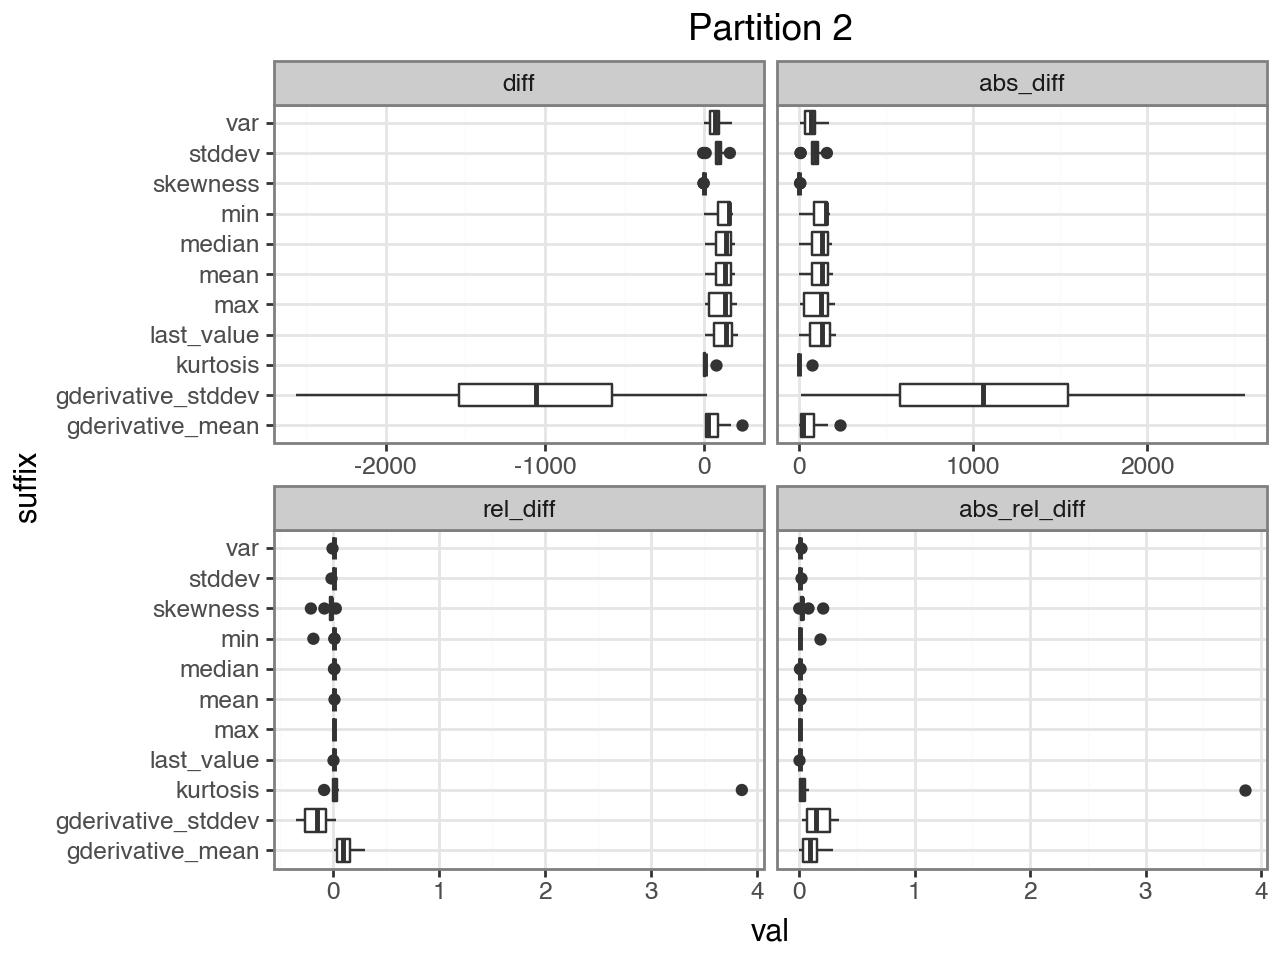

/Users/vkverma/research/Projection-Effects/env/lib/python3.12/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_boxplot : Removed 572 rows containing non-finite values.


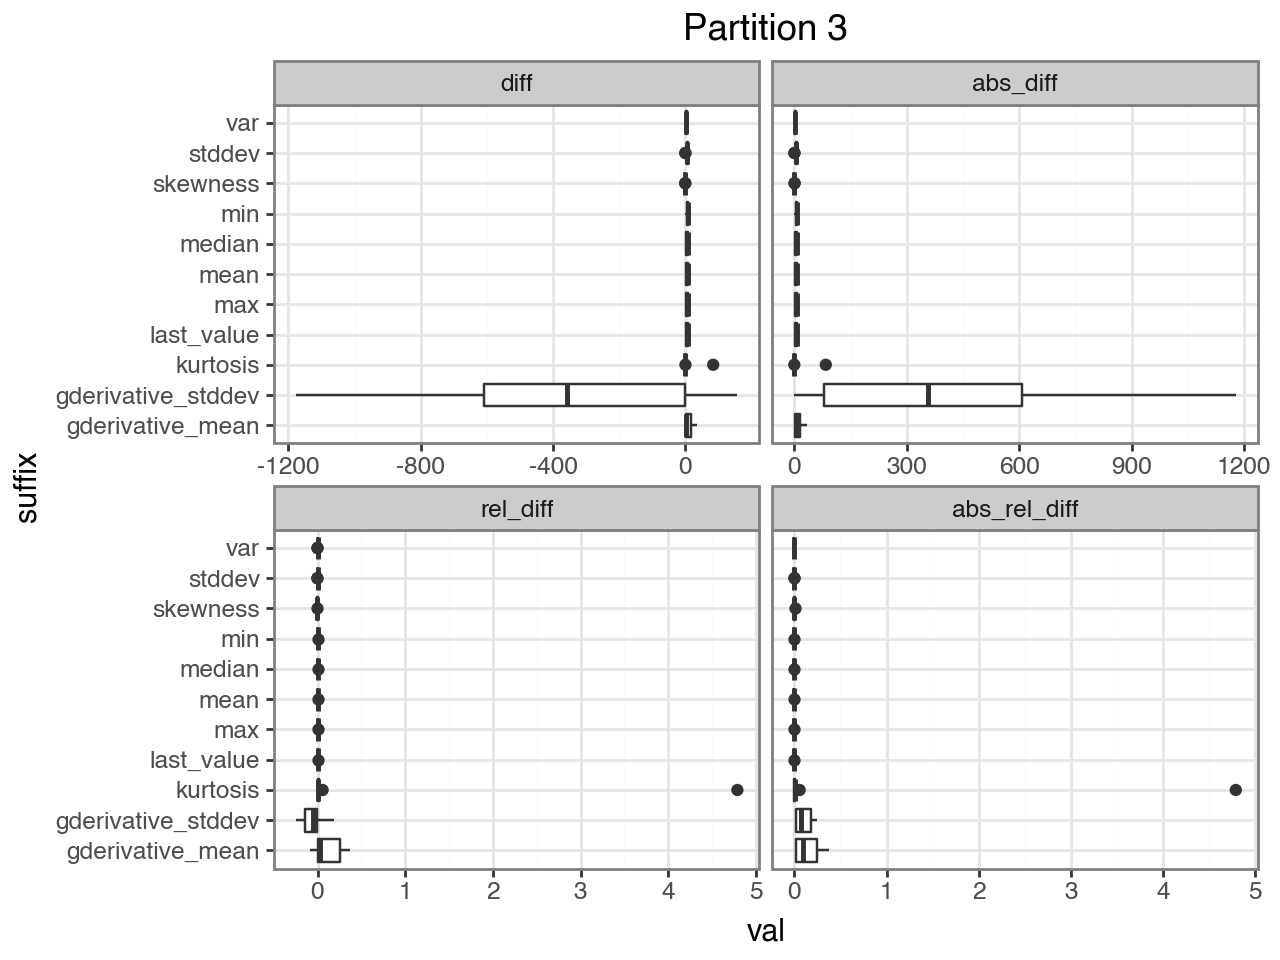

/Users/vkverma/research/Projection-Effects/env/lib/python3.12/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_boxplot : Removed 572 rows containing non-finite values.


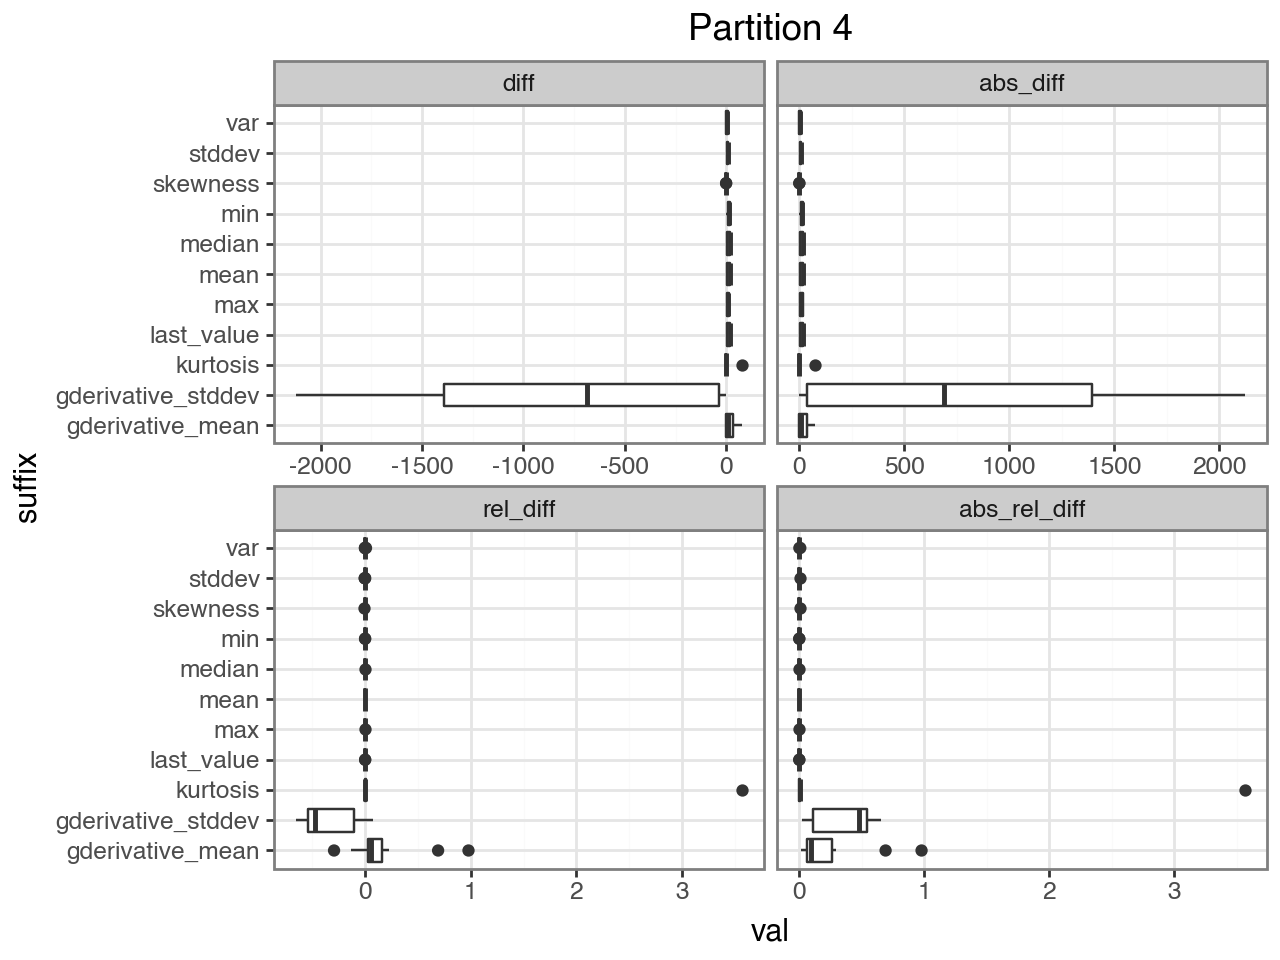

/Users/vkverma/research/Projection-Effects/env/lib/python3.12/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_boxplot : Removed 572 rows containing non-finite values.


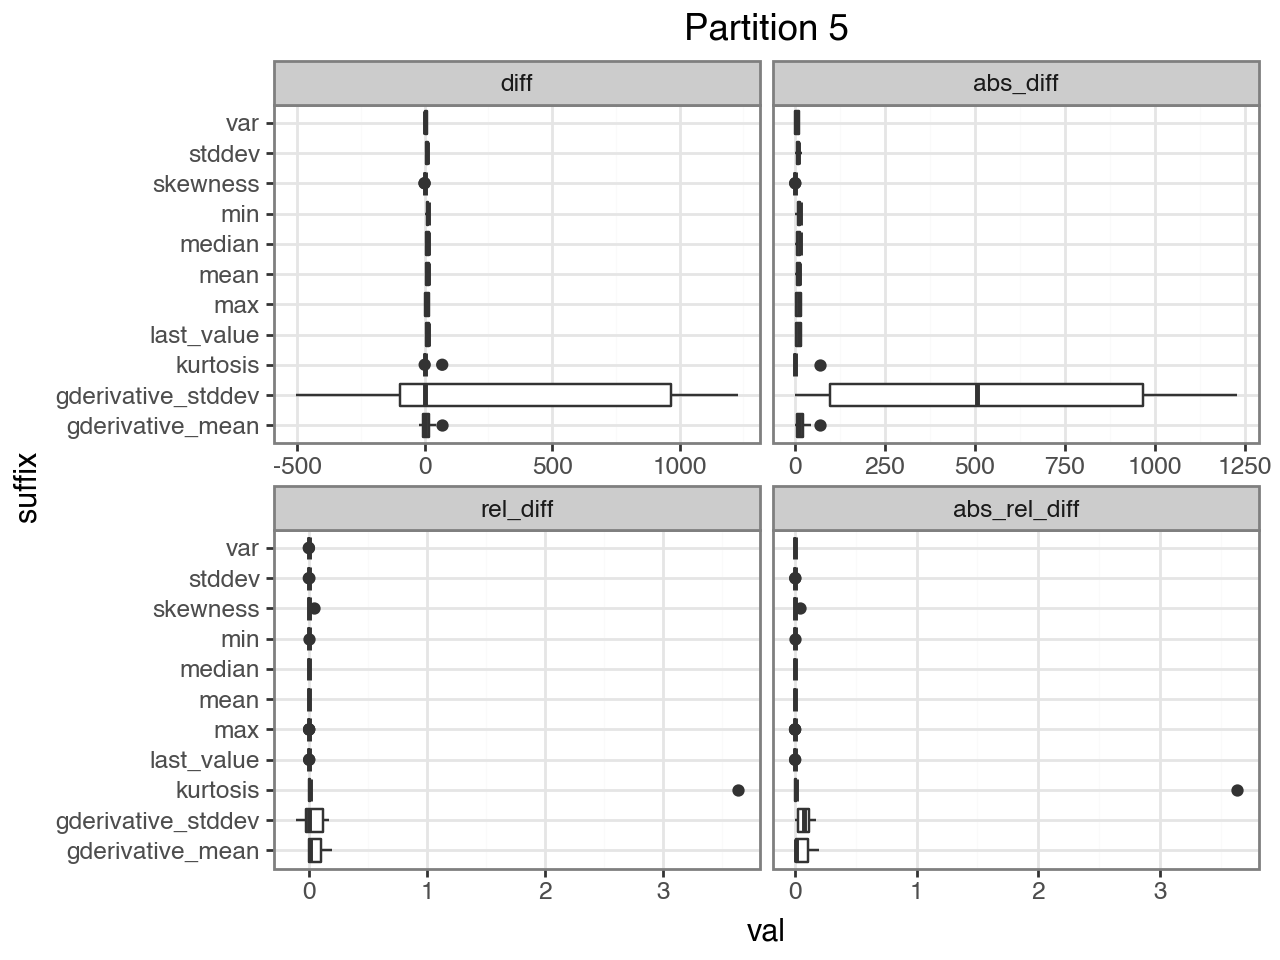

In [6]:
for partition in range(1, 6):
    make_comparison_plot(comparisons[partition - 1], partition).show()

In [7]:
for partition in range(1, 6):
    all_fisher_scores[partition - 1].to_parquet(f"partition{partition}.parquet")